# DDoS Attack Detection

### Before execution :

In [ ]:
!pip install --upgrade pip


In [ ]:
! pip install tensorflow

In [ ]:
! pip install protos

In [ ]:
pip --default-timeout=1000 install tensorflow

In [ ]:
! pip install keras
! pip install scikit-learn

## 1. Importing all necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sklearn.metrics
from sklearn.linear_model import LogisticRegression

import seaborn as sns; sns.set()
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical
#from keras.utils import np_utils
import keras.metrics
import numpy as np
from keras.models import Sequential
import keras.metrics
from keras.layers import Dense
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

In [2]:
# Set the maximum number of rows displayed
pd.set_option('display.max_rows', 100)  # Adjust the number as needed

# Set the maximum number of columns displayed
pd.set_option('display.max_columns', 100)  # Adjust the number as needed

## 2. Loading the dataset

### 2.1  Specifying the number of rows included in dataset

number_of_samples :                                                                                                                                    determines how many samples from the attack and normal dataset should be read and used.

In [3]:
number_of_samples = 70000  

## 2.2 Reading the datasets and assigning columns

In [4]:
data_attack = pd.read_csv('dataset_attack.csv', nrows = number_of_samples)

In [5]:
data_normal = pd.read_csv('dataset_normal.csv', nrows = number_of_samples)

In [6]:
data_normal.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']
data_attack.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']

## 2.3 Dropping unwanted columns

In [7]:
data_normal=data_normal.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)
data_attack=data_attack.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)

In [8]:
features=[ 'frame.len', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta']

---

## 3. Exploratory Data Analysis

In [9]:
data_normal.describe()

,frame.len,ip.hdr_len,ip.len,ip.flags.rb,ip.flags.df,p.flags.mf,ip.frag_offset,ip.ttl,ip.proto,tcp.srcport,tcp.dstport,tcp.len,tcp.ack,tcp.flags.res,tcp.flags.ns,tcp.flags.cwr,tcp.flags.ecn,tcp.flags.urg,tcp.flags.ack,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.fin,tcp.window_size,tcp.time_delta
count,70000.000000,70000.000000,70000.000000,70000.0,70000.000000,70000.0,70000.0,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,7.000000e+04,70000.0,70000.0,70000.0,70000.0,70000.0,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,674.386557,19.958571,658.444057,0.0,0.976786,0.0,0.0,91.715400,6.185614,2055.788714,4300.068886,616.324743,7.989599e+06,0.0,0.0,0.0,0.0,0.0,0.961543,0.273414,0.006671,0.030686,0.025143,14440.378557,0.410494
std,680.583272,0.909322,682.341868,0.0,0.150585,0.0,0.0,48.822167,1.491804,6216.739529,8010.195087,683.930735,1.529793e+08,0.0,0.0,0.0,0.0,0.0,0.192299,0.445715,0.081406,0.172466,0.156560,17104.069093,5.137949
min,60.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,20.000000,40.000000,0.0,1.000000,0.0,0.0,63.000000,6.000000,22.000000,80.000000,0.000000,3.440000e+02,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,7504.000000,0.000161
50%,142.000000,20.000000,128.000000,0.0,1.000000,0.0,0.0,64.000000,6.000000,80.000000,2985.000000,80.000000,1.215000e+03,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,7504.000000,0.001090
75%,1514.000000,20.000000,1500.000000,0.0,1.000000,0.0,0.0,128.000000,6.000000,2490.000000,4501.000000,1460.000000,2.151000e+03,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,17224.000000,0.003445
max,1514.000000,20.000000,1500.000000,0.0,1.000000,0.0,0.0,255.000000,17.000000,58697.000000,58697.000000,1460.000000,4.271142e+09,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,200020.000000,154.989781


In [10]:
data_attack.describe()

,frame.len,ip.hdr_len,ip.len,ip.flags.rb,ip.flags.df,p.flags.mf,ip.frag_offset,ip.ttl,ip.proto,tcp.srcport,tcp.dstport,tcp.len,tcp.ack,tcp.flags.res,tcp.flags.ns,tcp.flags.cwr,tcp.flags.ecn,tcp.flags.urg,tcp.flags.ack,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.fin,tcp.window_size,tcp.time_delta
count,70000.000000,70000.000000,70000.000000,70000.0,70000.000000,70000.0,70000.0,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,7.000000e+04,70000.0,70000.0,70000.0,70000.0,70000.0,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,554.187014,19.982400,538.921614,0.0,0.590857,0.0,0.0,97.806743,10.164700,6148.430143,6754.340800,354.288757,5.359247e+06,0.0,0.0,0.0,0.0,0.0,0.610214,0.174771,0.002371,0.017157,0.010000,12857.768829,0.106188
std,616.392870,0.595347,617.411984,0.0,0.491679,0.0,0.0,31.822304,5.344531,15938.833951,16201.683517,590.644170,1.310610e+08,0.0,0.0,0.0,0.0,0.0,0.487705,0.379774,0.048640,0.129858,0.099499,20343.668412,0.860466
min,60.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62.000000,20.000000,48.000000,0.0,0.000000,0.0,0.0,64.000000,6.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,190.000000,20.000000,176.000000,0.0,1.000000,0.0,0.0,110.000000,6.000000,22.000000,80.000000,0.000000,2.530000e+02,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,7504.000000,0.000178
75%,1434.000000,20.000000,1420.000000,0.0,1.000000,0.0,0.0,128.000000,17.000000,2114.000000,3856.000000,512.000000,1.647000e+03,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,16384.000000,0.001314
max,1514.000000,24.000000,1500.000000,0.0,1.000000,0.0,0.0,255.000000,17.000000,64277.000000,64277.000000,1460.000000,4.267535e+09,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,100740.000000,77.630205


In [10]:
combined_df = pd.concat([data_attack,data_normal], axis=0)


combined_df = combined_df.reset_index(drop=True)

### 3.1 Number of null values :

In [11]:
combined_df.isnull().sum().sum()

0

### 3.2 Correlations :

In [12]:
combined_df.corr()

C:\Users\Asus\AppData\Local\Temp\ipykernel_13832\2236743958.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  combined_df.corr()


,frame.len,ip.hdr_len,ip.len,ip.flags.rb,ip.flags.df,p.flags.mf,ip.frag_offset,ip.ttl,ip.proto,tcp.srcport,tcp.dstport,tcp.len,tcp.ack,tcp.flags.res,tcp.flags.ns,tcp.flags.cwr,tcp.flags.ecn,tcp.flags.urg,tcp.flags.ack,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.fin,tcp.window_size,tcp.time_delta
frame.len,1.000000,0.032066,0.999988,NaN,0.170557,NaN,NaN,-0.297902,-0.144250,-0.008930,0.013566,0.914797,-0.039820,NaN,NaN,NaN,NaN,NaN,0.174383,-0.229308,-0.057289,-0.132540,-0.098756,-0.037415,-0.050896
ip.hdr_len,0.032066,1.000000,0.035187,NaN,0.073117,NaN,NaN,0.088062,0.071392,0.012838,0.016531,0.028569,0.001799,NaN,NaN,NaN,NaN,NaN,0.073564,0.020636,0.002588,0.006011,0.005135,0.027863,0.002691
ip.len,0.999988,0.035187,1.000000,NaN,0.169447,NaN,NaN,-0.297735,-0.142562,-0.008939,0.013103,0.914707,-0.040051,NaN,NaN,NaN,NaN,NaN,0.173126,-0.227514,-0.057623,-0.131898,-0.099252,-0.037808,-0.051004
ip.flags.rb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ip.flags.df,0.170557,0.073117,0.169447,NaN,1.000000,NaN,NaN,-0.179026,-0.882926,0.078342,0.113209,0.353865,0.020086,NaN,NaN,NaN,NaN,NaN,0.854673,0.247735,0.030996,0.079716,0.067593,0.274830,0.029434
p.flags.mf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ip.frag_offset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ip.ttl,-0.297902,0.088062,-0.297735,NaN,-0.179026,NaN,NaN,1.000000,0.227395,-0.001152,-0.082491,-0.327302,0.037687,NaN,NaN,NaN,NaN,NaN,-0.232401,-0.061961,0.036550,-0.019874,0.007291,0.092993,0.029685
ip.proto,-0.144250,0.071392,-0.142562,NaN,-0.882926,NaN,NaN,0.227395,1.000000,-0.165314,-0.212864,-0.367875,-0.023167,NaN,NaN,NaN,NaN,NaN,-0.947254,-0.265722,-0.033323,-0.077405,-0.066126,-0.358778,-0.034647
tcp.srcport,-0.008930,0.012838,-0.008939,NaN,0.078342,NaN,NaN,-0.001152,-0.165314,1.000000,-0.084651,0.028487,0.014640,NaN,NaN,NaN,NaN,NaN,0.154026,0.096364,0.030731,-0.006838,-0.004419,0.356642,0.020807


### 3.3 Pairplots

In [ ]:
# Create pairplots of the DataFrame
sns.pairplot(combined_df)

# Show the pairplots
plt.show()

---

## 4. Preparing data for baseline models 

In [12]:
afeatures = features.copy()

In [13]:
afeatures.append('class')

### 4.1 Combining the two datasets :

In [14]:
total_ds = pd.concat([data_normal, data_attack], ignore_index=True)

### 4.2 Splitting to input and target features :

In [16]:
X = total_ds.drop('class', axis=1)
Y = total_ds['class'] 

In [17]:
Y = Y.replace({'normal': 0, 'attack': 1})

### 4.3 Standardizing and scaling the values

In [18]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

### 4.4 Splitting to training and testing sets 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

---

## 5. Training and testing on baseline models

### 5.1 Random Forest Classifier

In [20]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [21]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
rf_y_pred = rf_classifier.predict(X_test)

#### Evaluating performance :

In [23]:
# Print classification report
print(classification_report(y_test,rf_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     28012
           1       0.98      0.96      0.97     27988

    accuracy                           0.97     56000
   macro avg       0.97      0.97      0.97     56000
weighted avg       0.97      0.97      0.97     56000



In [24]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test,rf_y_pred))

Confusion Matrix:
[[27333   679]
 [ 1238 26750]]


In [25]:
# Accuracy
accuracy = accuracy_score(y_test,rf_y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9657678571428572


In [26]:
# Recall
rf_recall = sklearn.metrics.recall_score(y_test,rf_y_pred)
print(rf_recall)

0.9557667571816493


In [27]:
# Precision
rf_precision = sklearn.metrics.precision_score(y_test,rf_y_pred)
print(rf_precision)

0.9752451784607532


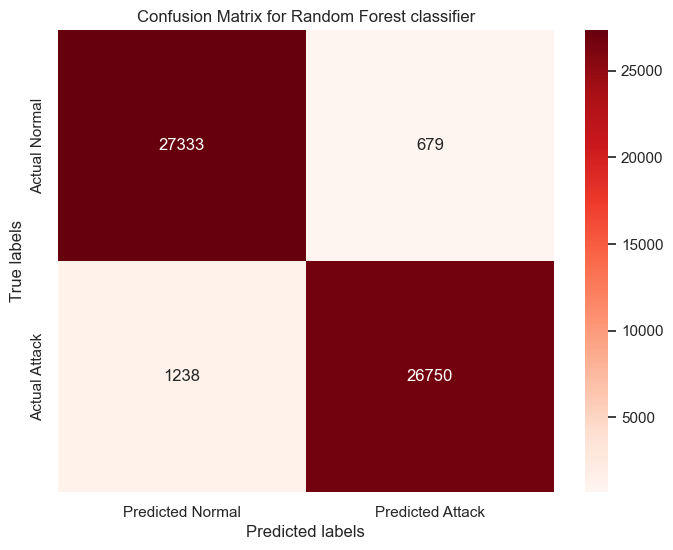

In [28]:
# Plot confusion matrix
rf_cm = confusion_matrix(y_test,rf_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, cmap='Reds', fmt='g', 
            xticklabels=['Predicted Normal', 'Predicted Attack'], 
            yticklabels=['Actual Normal', 'Actual Attack'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest classifier')
plt.savefig('Confusion Matrix for Random Forest classifier.jpg')
plt.show()

### 5.2 Logistic Regression :

In [29]:
modelL = LogisticRegression()

In [30]:
modelL.fit(X_train, y_train)

LogisticRegression()

In [31]:
LR_y_pred = modelL.predict(X_test)

#### Evaluating performance :

In [32]:
print("Classification Report:")
print(classification_report(y_test,LR_y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     28012
           1       0.92      0.60      0.73     27988

    accuracy                           0.77     56000
   macro avg       0.81      0.77      0.77     56000
weighted avg       0.81      0.77      0.77     56000



In [33]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,LR_y_pred))

Confusion Matrix:
[[26463  1549]
 [11069 16919]]


In [34]:
# Accuracy
accuracy = accuracy_score(y_test,LR_y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7746785714285714


In [35]:
# Precision 
LR_precision = sklearn.metrics.precision_score(y_test,LR_y_pred)
print(LR_precision)

0.9161251895170024


In [36]:
# Recall
LR_recall = sklearn.metrics.recall_score(y_test,LR_y_pred)
print(LR_recall)

0.6045090753179935


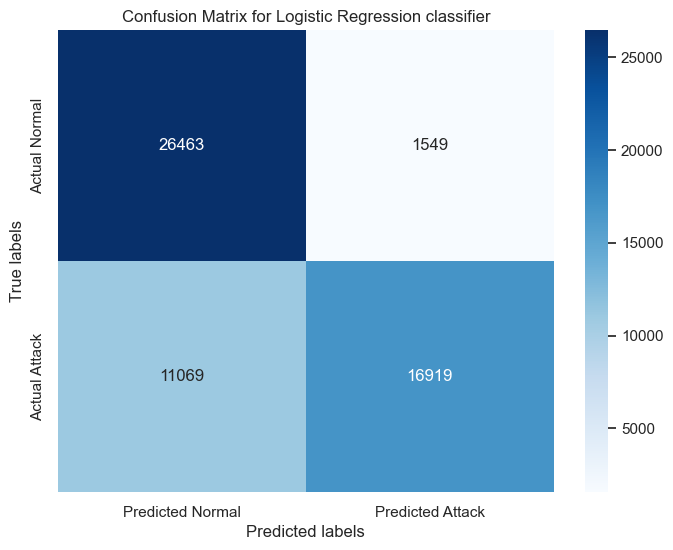

In [37]:
# Plot confusion matrix
rf_cm = confusion_matrix(y_test,LR_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Predicted Normal', 'Predicted Attack'], 
            yticklabels=['Actual Normal', 'Actual Attack'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression classifier')
plt.savefig('Confusion Matrix for Logistic Regression classifier')
plt.show()

---

## 5.3 Feedforward neural network (1 hidden layer)

In [23]:
# Create a Sequential model
modelx = Sequential()

# Add the input layer (Dense layer with ReLU activation)
modelx.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))

# Add a hidden layer (Dense layer with ReLU activation)
modelx.add(Dense(units=32, activation='relu'))

# Add the output layer (Dense layer with sigmoid activation for binary classification)
modelx.add(Dense(units=1, activation='sigmoid'))

# Compile the model
modelx.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall(),keras.metrics.TruePositives(),keras.metrics.TrueNegatives(),keras.metrics.FalsePositives(),keras.metrics.FalseNegatives()])

In [31]:
history3=modelx.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
 108/2100 [>.............................] - ETA: 2s - loss: 0.3555 - accuracy: 0.8356 - precision: 0.9541 - recall: 0.6985 - true_positives: 1184.0000 - true_negatives: 1704.0000 - false_positives: 57.0000 - false_negatives: 511.0000

C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


2100/2100 [==============================] - 4s 2ms/step - loss: 0.3659 - accuracy: 0.8270 - precision: 0.9553 - recall: 0.6861 - true_positives: 23060.0000 - true_negatives: 32512.0000 - false_positives: 1080.0000 - false_negatives: 10548.0000 - val_loss: 0.3604 - val_accuracy: 0.8252 - val_precision: 0.9725 - val_recall: 0.6694 - val_true_positives: 5626.0000 - val_true_negatives: 8237.0000 - val_false_positives: 159.0000 - val_false_negatives: 2778.0000
Epoch 2/50
2100/2100 [==============================] - 4s 2ms/step - loss: 0.3624 - accuracy: 0.8267 - precision: 0.9563 - recall: 0.6848 - true_positives: 23016.0000 - true_negatives: 32540.0000 - false_positives: 1052.0000 - false_negatives: 10592.0000 - val_loss: 0.3543 - val_accuracy: 0.8304 - val_precision: 0.9541 - val_recall: 0.6943 - val_true_positives: 5835.0000 - val_true_negatives: 8115.0000 - val_false_positives: 281.0000 - val_false_negatives: 2569.0000
Epoch 3/50
2100/2100 [==============================] - 3s 2ms/step

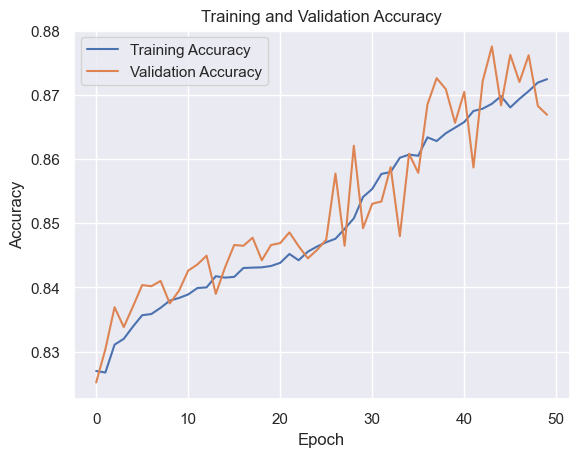

In [32]:
# Plot training and validation accuracy over epochs
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('ANN Training and Validation Accuracy')
plt.legend()
plt.show()

In [33]:
scores = modelx.evaluate(X_test, y_test, verbose=1)

1750/1750 [==============================] - 2s 1ms/step - loss: 0.2657 - accuracy: 0.8629 - precision: 0.9327 - recall: 0.7821 - true_positives: 21890.0000 - true_negatives: 26432.0000 - false_positives: 1580.0000 - false_negatives: 6098.0000


In [34]:
scores = modelx.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (modelx.metrics_names[1], scores[1]*100))

accuracy: 86.29%


In [35]:
tp = int(scores[4])
tn = int(scores[5])
fp = int(scores[6])
fn = int(scores[7])

In [38]:
for x in range(len(modelx.metrics_names)):
    print(modelx.metrics_names[x],': ',scores[x])
#print(scores)

loss :  0.2657300531864166
accuracy :  0.8628928661346436
precision :  0.9326800107955933
recall :  0.7821208834648132
true_positives :  21890.0
true_negatives :  26432.0
false_positives :  1580.0
false_negatives :  6098.0


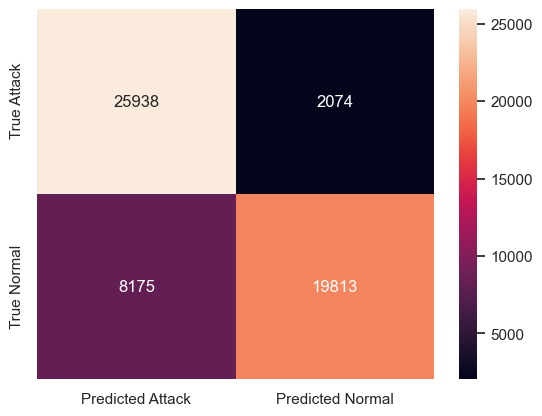

In [29]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = [" True Attack","True Normal"],columns = ["Predicted Attack","Predicted Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [ ]:
figure = ax.get_figure()    
figure.savefig('confusion_matrix_ANN.png', dpi=400)

---

## 6. Training and testing on proposed model

In [79]:
number_of_samples = 50000

In [85]:
data_attack1 = pd.read_csv('dataset_attack.csv', nrows = number_of_samples)

In [86]:
data_normal1 = pd.read_csv('dataset_normal.csv', nrows = number_of_samples)

In [87]:
data_normal1.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']
data_attack1.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']

In [88]:
data_normal1=data_normal1.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)
data_attack1=data_attack1.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)

In [89]:
features1=[ 'frame.len', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta']

In [90]:
X_normal1= data_normal1[features1].values
X_attack1= data_attack1[features1].values
Y_normal1= data_normal1['class']
Y_attack1= data_attack1['class']


X=np.concatenate((X_normal1,X_attack1))
Y=np.concatenate((Y_normal1,Y_attack1))


In [91]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [92]:
for i in range(0,len(Y)):
  if Y[i] =="attack":
    Y[i]=0
  else:
    Y[i]=1
    

In [93]:
features = len(X[0])
samples = X.shape[0]
train_len = 25
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [94]:
X.shape

(100000, 25)

In [95]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[25:100000], test_size = 0.2)

In [96]:
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)

In [97]:
def create_LSTM():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy',keras.metrics.Precision(),keras.metrics.Recall(),keras.metrics.F1Score(),keras.metrics.TruePositives(),keras.metrics.TrueNegatives(),keras.metrics.FalsePositives(),keras.metrics.FalseNegatives()])
    
    return model

In [98]:
model = create_LSTM()

In [99]:
history = model.fit(X_train, Y_train, epochs = 50 ,validation_split=0.2, verbose = 1)

Epoch 1/50
2000/2000 [==============================] - 26s 11ms/step - loss: 0.2961 - accuracy: 0.9351 - precision_1: 0.9088 - recall_1: 0.9674 - f1_score: 0.6672 - true_positives_1: 30988.0000 - true_negatives_1: 28845.0000 - false_positives_1: 3108.0000 - false_negatives_1: 1043.0000 - val_loss: 0.1841 - val_accuracy: 0.9526 - val_precision_1: 0.9467 - val_recall_1: 0.9592 - val_f1_score: 0.6664 - val_true_positives_1: 7667.0000 - val_true_negatives_1: 7571.0000 - val_false_positives_1: 432.0000 - val_false_negatives_1: 326.0000
Epoch 2/50
2000/2000 [==============================] - 22s 11ms/step - loss: 0.1731 - accuracy: 0.9576 - precision_1: 0.9344 - recall_1: 0.9845 - f1_score: 0.6672 - true_positives_1: 31535.0000 - true_negatives_1: 29738.0000 - false_positives_1: 2215.0000 - false_negatives_1: 496.0000 - val_loss: 0.1468 - val_accuracy: 0.9627 - val_precision_1: 0.9387 - val_recall_1: 0.9900 - val_f1_score: 0.6664 - val_true_positives_1: 7913.0000 - val_true_negatives_1: 748

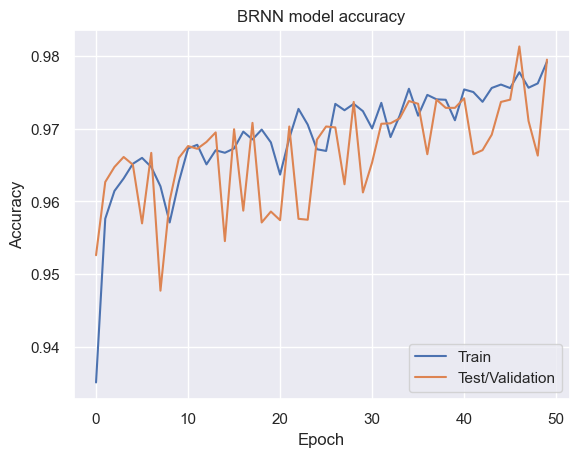

In [100]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['precision_1'])
#plt.plot(history.history['precision'])
plt.title('BRNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test/Validation'],loc='lower right')
plt.savefig('BRNN Model Accuracy.png')
plt.show()

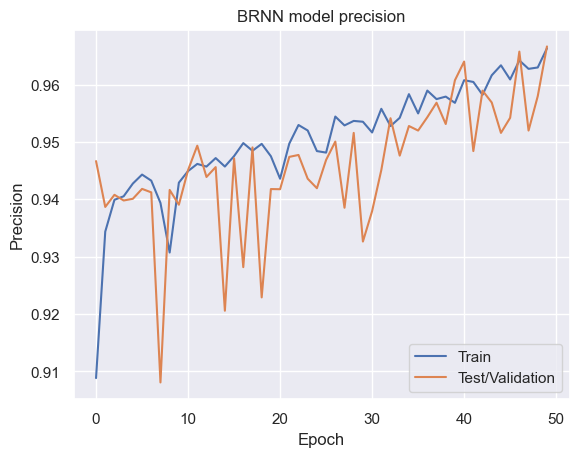

In [102]:
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.title('BRNN model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train','Test/Validation'],loc='lower right')
plt.savefig('BRNN Model Precision.png')
plt.show()

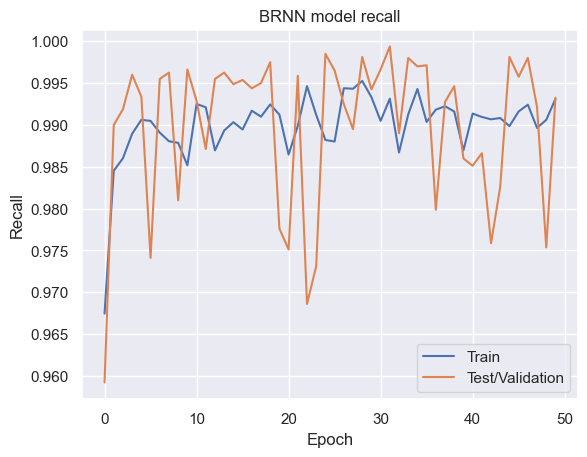

In [104]:
# Plot training & validation recall values
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('BRNN model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train','Test/Validation'],loc='lower right')
plt.savefig('BRNN Model recall.png')
plt.show()

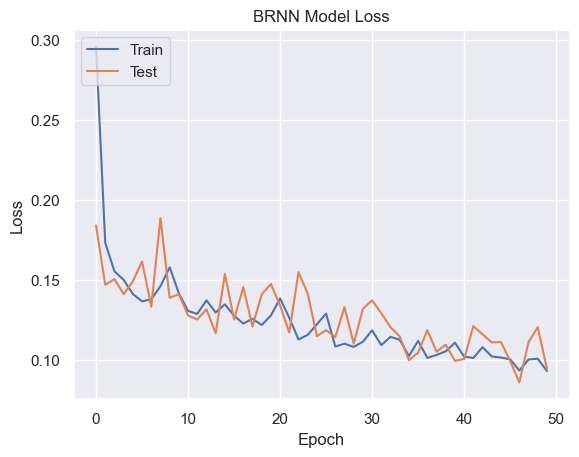

In [105]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN Model Loss.png')
plt.show()

In [106]:
X_test = np.asarray(X_test).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

In [111]:
print(model.metrics_names)

['loss', 'accuracy', 'precision_1', 'recall_1', 'f1_score', 'true_positives_1', 'true_negatives_1', 'false_positives_1', 'false_negatives_1']


In [112]:
scores1 = model.evaluate(X_test, Y_test, verbose=0)

In [114]:
for y in range(len(model.metrics_names)):
    print(model.metrics_names[y],": ",scores1[y])

loss :  0.09623981267213821
accuracy :  0.9804950952529907
precision_1 :  0.9676220417022705
recall_1 :  0.9940709471702576
f1_score :  [0.66459626]
true_positives_1 :  9892.0
true_negatives_1 :  9713.0
false_positives_1 :  331.0
false_negatives_1 :  59.0


In [115]:
tp1 = int(scores[5])
tn1 = int(scores[6])
fp1 = int(scores[7])
fn1 = int(scores[8])

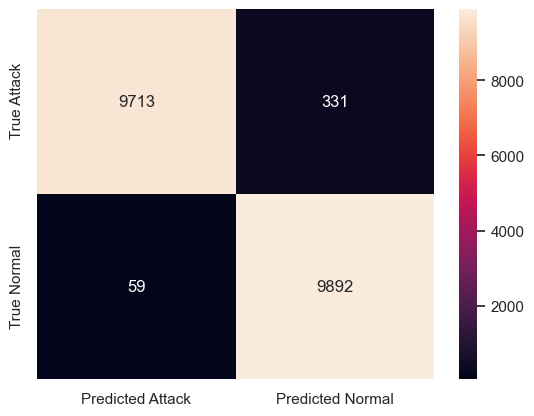

In [117]:
to_heat_map =[[tn1,fp1],[fn1,tp1]]
to_heat_map = pd.DataFrame(to_heat_map, index = [" True Attack","True Normal"],columns = ["Predicted Attack","Predicted Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

## 7. Evaluating all results

In [118]:
data_types = {
    'Method': str,
    'Accuracy': float,
    'Precision': float,
    'Recall':float
}

In [119]:
df = pd.DataFrame(columns=data_types.keys())

In [120]:
df = df.astype(data_types)

In [121]:
row1 = {'Method': 'LOGISTIC REGRESSION', 'Accuracy': 77.15, 'Precision': 91.08,'Recall':60.10}
row2 = {'Method': 'RANDOM FOREST', 'Accuracy': 96.66, 'Precision': 97.83,'Recall':95.44}
row3 = {'Method':'ANN','Accuracy':86.78,'Precision':92.49,'Recall':79.99}
row4 = {'Method': 'BIDIRECTIONAL LSTM', 'Accuracy': 98.12, 'Precision': 96.81,'Recall':99.51,}

In [122]:
df=df.append(row1,ignore_index=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_13832\3739454826.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row1,ignore_index=True)


In [123]:
df=df.append(row2,ignore_index=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_13832\3508064295.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row2,ignore_index=True)


In [124]:
df=df.append(row3,ignore_index=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_13832\920509508.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row3,ignore_index=True)


In [125]:
df=df.append(row4,ignore_index=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_13832\3302492021.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(row4,ignore_index=True)


In [126]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')

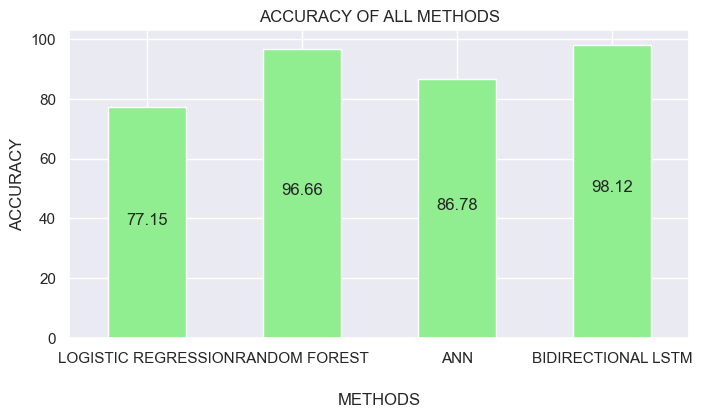

In [127]:
df.plot(kind='bar', x='Method', y='Accuracy',figsize=(8,4),color='lightgreen',legend=False)

addlabels(df['Method'],df['Accuracy'])
# Adding titles and labels
plt.title('ACCURACY OF ALL METHODS')
plt.xlabel('METHODS',labelpad=20)
plt.ylabel('ACCURACY')
plt.savefig('Accuracies.png')
plt.xticks(rotation=0)
# Show the plot
plt.show()

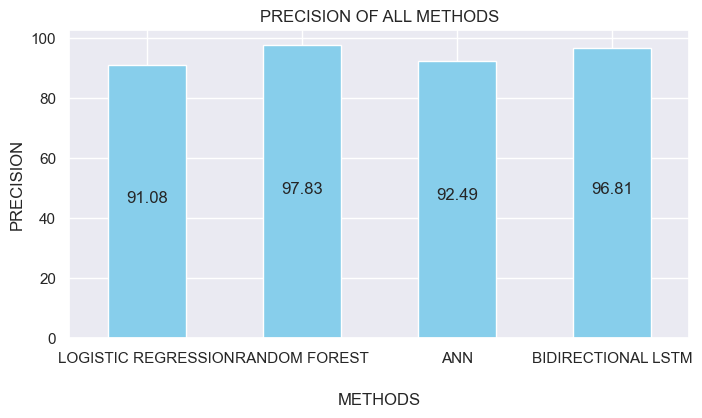

In [128]:
df.plot(kind='bar', x='Method', y='Precision',figsize=(8,4), color='skyblue',legend=False)

addlabels(df['Method'],df['Precision'])
# Adding titles and labels
plt.title('PRECISION OF ALL METHODS')
plt.xlabel('METHODS',labelpad=20)
plt.ylabel('PRECISION')
plt.xticks(rotation=0)
plt.savefig('Precisions.jpeg')
# Show the plot
plt.show()

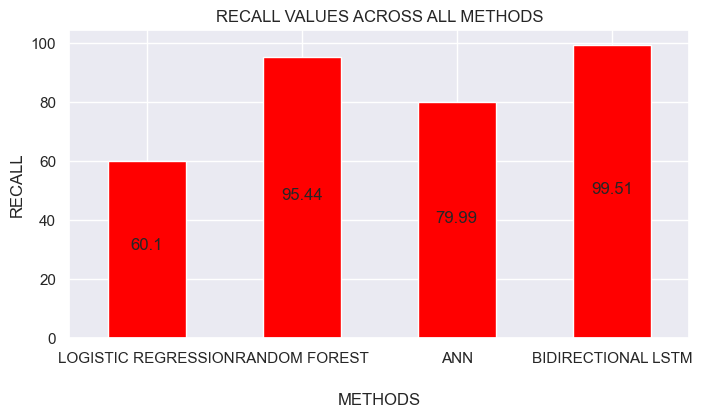

In [129]:
df.plot(kind='bar', x='Method', y='Recall',figsize=(8,4),color='red',legend=False)

addlabels(df['Method'],df['Recall'])
# Adding titles and labels
plt.title('RECALL VALUES ACROSS ALL METHODS')
plt.xlabel('METHODS',labelpad=20)
plt.ylabel('RECALL')
plt.xticks(rotation=0)
plt.savefig('Recalls.jpeg')
# Show the plot
plt.show()